In [1]:
import h5py
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools 
import pyts
from pyts.approximation import PiecewiseAggregateApproximation

from sklearn.utils import class_weight

import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Convolution2D,Conv2D, Dense,Dropout, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D, TimeDistributed, GRU, LSTM

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')

try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

2022-02-11 20:10:13.785675: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


2.5.0
Num GPUs Available:  1


2022-02-11 20:10:14.594724: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2022-02-11 20:10:14.629930: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-11 20:10:14.629981: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-11 20:10:14.634031: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-11 20:10:14.634102: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11
2022-02-11 20:10:14.635572: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library li

In [2]:
from os import environ
dataset = environ['dataset']
print(dataset)

redd_gen_GASF_13m_100S5X5A4934_R42_80-20


In [3]:
#my defs 
from modules.models import  LSTM_3D_V56, CNN_V56,LSTM_BI_V56
from modules.tools import my_print, plot_confusion_matrix_norm, get_data,get_data_split, evaluate_model, create_tl_model
from modules.HDF5ImageGenerator import HDF5ImageGenerator

In [4]:
#LOAD DATASET
#file_name = "ukdale_gen_GASF_13m_100S5X12A54480"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006"
file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42-80-20"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42_80-20"
file_name = "refit_gen_GASF_60m_300S0X_15A157030N_R12_80-20-V1"
file_name = environ["dataset"]
#read the file
path = str(pathlib.Path().resolve())

path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"

file = h5py.File(path_data,"r+")

In [5]:
x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)

['fridge/freezer', 'electric furnace', 'light', 'microwave', 'sockets']
{0: 1.3540308747855918, 1: 2.1335135135135137, 2: 0.5634546752319771, 3: 3.5881818181818184, 4: 0.5749453750910415}
 
Tests 
fridge/freezer test: 146 train: 583
electric furnace test: 92 train: 370
light test: 351 train: 1401
microwave test: 55 train: 220
sockets test: 343 train: 1373


In [6]:
def select_model(learn_type):
    
    if learn_type == "CNN":
        model = CNN_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "LSTM":
        model = LSTM_3D_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "BI_LSTM":
        model = LSTM_BI_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    return model
              

In [7]:
path_save = path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']
path_save_nb = path_save+"_out.ipynb"
path_save_log = path_save+"_out_log2.txt"

In [8]:
from keras.callbacks import LambdaCallback
#path_log= path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']+"_log.txt"
txt_log = open(path_save+"_log.txt", mode='wt', buffering=1)
txt_log.write("file created! \n")

save_op_callback = LambdaCallback(
  on_epoch_end = lambda epoch, logs: txt_log.write(
    str({'epoch': epoch, 'loss': logs['loss'],'acc': logs['accuracy']}) + '\n'),
                                                           
)

In [9]:
print(path_save_nb)

/workspace/notebooks/experiment_automation/output/BI_LSTM/redd/TL/redd_42_refit, iawe, eco, ukdale_out.ipynb


In [10]:
# rm $path_save_log

In [11]:
# %%capture cap 

# with open(path_save_log,"wt") as f:
#     f.write(cap.stdout)
    
# print("out capture..")

In [12]:
# %%capture cap --no-stderr


if environ['train_type'] == "BB":

    #define generator
    train_gen = HDF5ImageGenerator(
        src= path_data,
        X_key="data/train/gaf",
        y_key="labels/train/gaf",
        classes_key="appliances/classes",
        labels_encoding="hot",
        shuffle=True,
        batch_size=int(environ['batch_size']),
        num_classes=num_of_classes,
        mode="train",
        )
    
    model = select_model(environ['learn_type'])
    
    txt_log.write("fitting BB model: \n")
    
    model.fit(
        train_gen,
        verbose=2,
        epochs=int(environ['epochs']),
        class_weight=d_class_weights,
        callbacks = [save_op_callback],
    )
    
    txt_log.write("finished fitting BB model: \n")

    evaluate_model(model,x_test,y_test,appliances)
    
    if environ['save_model']=="True":

        path_model_save = path+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]
        model.save(path_model_save)
        txt_log.write("model saved to:"+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]+" \n")
        
        
# with open(path_save+"_out_log.txt" as f:
#     f.write(cap.stdout)


In [13]:
#model = keras.models.load_model(path_model1)
# model_used = model

In [14]:
# evaluate_model(model,x_test,y_test,appliances)

using dataset data redd training on model refit seed 42
reading data, printing stats: 
['fridge/freezer', 'electric furnace', 'light', 'microwave', 'sockets']
{0: 1.3540308747855918, 1: 2.1335135135135137, 2: 0.5634546752319771, 3: 3.5881818181818184, 4: 0.5749453750910415}
 
Tests 
fridge/freezer test: 146 train: 583
electric furnace test: 92 train: 370
light test: 351 train: 1401
microwave test: 55 train: 220
sockets test: 343 train: 1373
loading model
compling TL model..


2022-02-11 20:10:15.350812: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-11 20:10:15.351144: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1872] Adding visible gpu devices: 0
2022-02-11 20:10:15.351195: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-11 20:10:15.714467: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-02-11 20:10:15.714504: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2022-02-11 20:10:15.714511: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2022-02-11 20:10:15.715092: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device 

Normal way
[0 1 2 3 4 5 6 7 8 9]
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-02-11 20:10:23.490342: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-11 20:10:23.508622: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3299990000 Hz


Epoch 1/50


2022-02-11 20:10:26.957785: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2022-02-11 20:10:27.423559: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2022-02-11 20:10:27.916557: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-11 20:10:28.332703: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


124/124 - 7s - loss: 0.8701 - accuracy: 0.5840
Epoch 2/50
124/124 - 3s - loss: 0.6303 - accuracy: 0.6985
Epoch 3/50
124/124 - 3s - loss: 0.5748 - accuracy: 0.7086
Epoch 4/50
124/124 - 3s - loss: 0.5612 - accuracy: 0.7195
Epoch 5/50
124/124 - 3s - loss: 0.5169 - accuracy: 0.7411
Epoch 6/50
124/124 - 3s - loss: 0.5203 - accuracy: 0.7309
Epoch 7/50
124/124 - 3s - loss: 0.5063 - accuracy: 0.7294
Epoch 8/50
124/124 - 3s - loss: 0.4909 - accuracy: 0.7335
Epoch 9/50
124/124 - 3s - loss: 0.4552 - accuracy: 0.7550
Epoch 10/50
124/124 - 3s - loss: 0.4621 - accuracy: 0.7444
Epoch 11/50
124/124 - 3s - loss: 0.4550 - accuracy: 0.7535
Epoch 12/50
124/124 - 3s - loss: 0.4635 - accuracy: 0.7588
Epoch 13/50
124/124 - 3s - loss: 0.4510 - accuracy: 0.7565
Epoch 14/50
124/124 - 3s - loss: 0.4417 - accuracy: 0.7624
Epoch 15/50
124/124 - 3s - loss: 0.4473 - accuracy: 0.7606
Epoch 16/50
124/124 - 3s - loss: 0.4268 - accuracy: 0.7659
Epoch 17/50
124/124 - 3s - loss: 0.4142 - accuracy: 0.7624
Epoch 18/50
124/1

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
124/124 - 6s - loss: 1.2367 - accuracy: 0.4520
Epoch 2/50
124/124 - 3s - loss: 1.0165 - accuracy: 0.5333
Epoch 3/50
124/124 - 3s - loss: 0.9465 - accuracy: 0.5293
Epoch 4/50
124/124 - 3s - loss: 0.8914 - accuracy: 0.5701
Epoch 5/50
124/124 - 3s - loss: 0.8727 - accuracy: 0.5670
Epoch 6/50
124/124 - 3s - loss: 0.8832 - accuracy: 0.5698
Epoch 7/50
124/124 - 3s - loss: 0.8598 - accuracy: 0.5647
Epoch 8/50
124/124 - 3s - loss: 0.8418 - accuracy: 0.5888
Epoch 9/50
124/124 - 3s - loss: 0.8256 - accuracy: 0.5954
Epoch 10/50
124/124 - 3s - loss: 0.8166 - accuracy: 0.5999
Epoch 11/50
124/124 - 3s - loss: 0.8090 - accuracy: 0.6070
Epoch 12/50
124/124 - 3s - loss: 0.8146 - accuracy: 0.5931
Epoch 13/50
124/124 - 3s - loss: 0.8078 - accuracy: 0.5946
Epoch 14/50
124/124 - 3s - loss: 0.7935 - accuracy: 0.6174
Epoch 15/50
124/124 - 3s - loss: 0.7757 - accuracy: 0.6141
Epoch 16/50
124/124 - 3s - loss: 0.7738 - accuracy: 0.6177
Epoch 17/50
124/124 - 3s - loss:

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
124/124 - 6s - loss: 0.9457 - accuracy: 0.5566
Epoch 2/50
124/124 - 3s - loss: 0.6864 - accuracy: 0.6706
Epoch 3/50
124/124 - 3s - loss: 0.6169 - accuracy: 0.7061
Epoch 4/50
124/124 - 3s - loss: 0.5814 - accuracy: 0.7094
Epoch 5/50
124/124 - 3s - loss: 0.5677 - accuracy: 0.7238
Epoch 6/50
124/124 - 3s - loss: 0.5661 - accuracy: 0.7236
Epoch 7/50
124/124 - 3s - loss: 0.5442 - accuracy: 0.7238
Epoch 8/50
124/124 - 3s - loss: 0.5335 - accuracy: 0.7304
Epoch 9/50
124/124 - 3s - loss: 0.5285 - accuracy: 0.7294
Epoch 10/50
124/124 - 3s - loss: 0.5047 - accuracy: 0.7418
Epoch 11/50
124/124 - 3s - loss: 0.5005 - accuracy: 0.7401
Epoch 12/50
124/124 - 3s - loss: 0.4848 - accuracy: 0.7466
Epoch 13/50
124/124 - 3s - loss: 0.4994 - accuracy: 0.7477
Epoch 14/50
124/124 - 3s - loss: 0.4989 - accuracy: 0.7517
Epoch 15/50
124/124 - 3s - loss: 0.4722 - accuracy: 0.7510
Epoch 16/50
124/124 - 3s - loss: 0.4611 - accuracy: 0.7530
Epoch 17/50
124/124 - 3s - loss:

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
124/124 - 6s - loss: 0.9919 - accuracy: 0.5313
Epoch 2/50
124/124 - 3s - loss: 0.7198 - accuracy: 0.6572
Epoch 3/50
124/124 - 3s - loss: 0.6576 - accuracy: 0.6772
Epoch 4/50
124/124 - 3s - loss: 0.6337 - accuracy: 0.6894
Epoch 5/50
124/124 - 3s - loss: 0.6186 - accuracy: 0.6889
Epoch 6/50
124/124 - 3s - loss: 0.5995 - accuracy: 0.6998
Epoch 7/50
124/124 - 3s - loss: 0.5995 - accuracy: 0.7031
Epoch 8/50
124/124 - 3s - loss: 0.5759 - accuracy: 0.7041
Epoch 9/50
124/124 - 3s - loss: 0.5600 - accuracy: 0.7137
Epoch 10/50
124/124 - 3s - loss: 0.5729 - accuracy: 0.7053
Epoch 11/50
124/124 - 3s - loss: 0.5508 - accuracy: 0.7188
Epoch 12/50
124/124 - 3s - loss: 0.5358 - accuracy: 0.7203
Epoch 13/50
124/124 - 3s - loss: 0.5468 - accuracy: 0.7162
Epoch 14/50
124/124 - 3s - loss: 0.5470 - accuracy: 0.7051
Epoch 15/50
124/124 - 3s - loss: 0.5211 - accuracy: 0.7216
Epoch 16/50
124/124 - 3s - loss: 0.5254 - accuracy: 0.7226
Epoch 17/50
124/124 - 3s - loss:

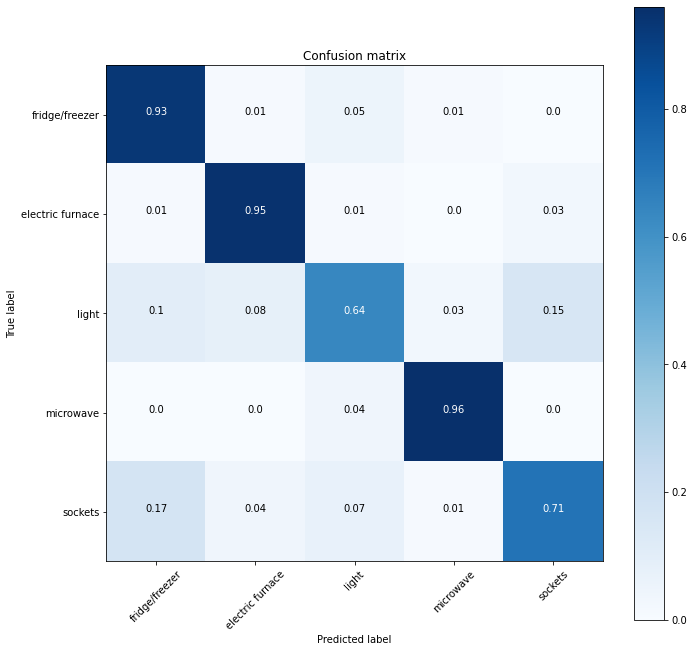

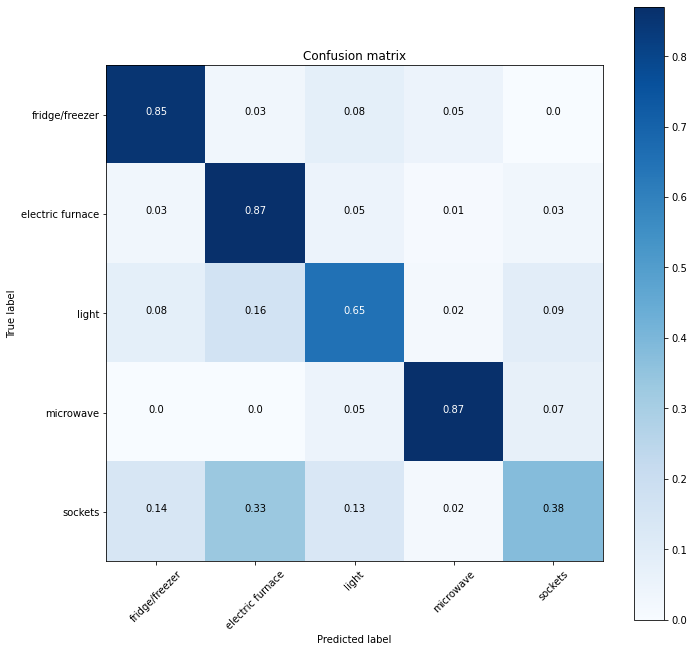

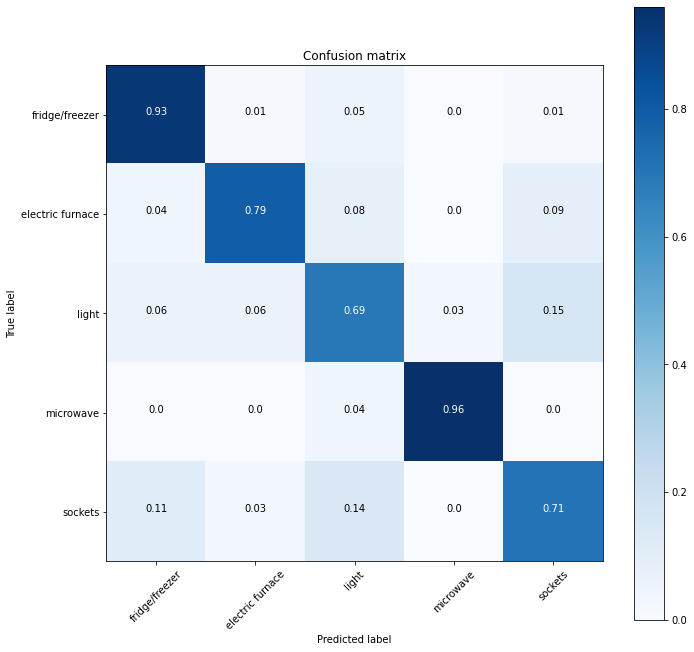

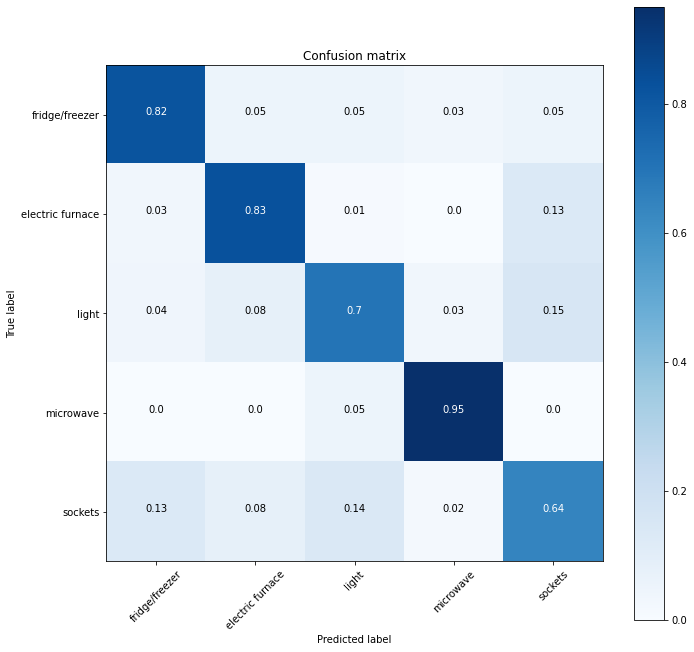

In [15]:
# datasets =[
#     "ukdale_gen_GASF_13m_100S5X12A54480_R82_80-20"
# ]

if environ['train_type'] == "TL": 
    models = environ['tl_datasets'].replace(" ","").split(",")
    #model = ["base"]
    
    for model in models:
    
        file_name = dataset
        
        datasetTL = model
        
        seed = dataset.split("_R")[1][0:2]
        
        print("using dataset data",dataset.split("_")[0],"training on model",model,"seed",environ['seed'])
        txt_log.write("starting "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        tf.keras.backend.clear_session()


        #read the file
        path = str(pathlib.Path().resolve())
        path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"
        file = h5py.File(path_data,"r+")


        print("reading data, printing stats: ")
        x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)
        print("loading model")
        
        model_seed = 42
        model_used = create_tl_model(model,environ['learn_type'],model_seed,path,num_of_classes)
                
        train_gen = HDF5ImageGenerator(
            src= path_data,
            X_key="data/train/gaf",
            y_key="labels/train/gaf",
            classes_key="appliances/classes",
            labels_encoding="hot",
            shuffle=True,
            batch_size=int(environ['batch_size']),
            num_classes=num_of_classes,
            mode="train",
            )

        model_used.fit(
            train_gen,
            verbose=2,
            epochs=int(environ['epochs']),
            class_weight=d_class_weights,
            callbacks = [save_op_callback]
            #workers = 6,
        )
        
        txt_log.write("finished "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        evaluate_model(model_used,x_test,y_test,appliances)
        



        #del model_used



In [16]:
txt_log.close()